In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [6]:
# Unmount first if something is broken
!fusermount -u drive

# Then mount again
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [7]:
import zipfile

zip_path = '/content/drive/MyDrive/cats_and_dogs.zip'
extract_path = '/content/cats_dogs_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [8]:
import os

print("Cats:", len(os.listdir(extract_path + "/Cat")))
print("Dogs:", len(os.listdir(extract_path + "/Dog")))



Cats: 12501
Dogs: 12501


In [9]:
cat_folder = '/content/cats_dogs_data/Cat'
dog_folder = '/content/cats_dogs_data/Dog'


In [10]:
def load_images(folder, label, max_images=2500):
    data = []
    labels = []
    count = 0

    for file in tqdm(os.listdir(folder)):
        if count >= max_images:
            break
        path = os.path.join(folder, file)
        if not (file.lower().endswith('.jpg') or file.lower().endswith('.jpeg') or file.lower().endswith('.png')):
            continue  # skip non-image files
        try:
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.resize(img, (64, 64))
            data.append(img.flatten())
            labels.append(label)
            count += 1
        except Exception as e:
            print(f"Error loading {file}: {e}")
    return data, labels

# Load cats and dogs
X_cat, y_cat = load_images(cat_folder, label=0)
X_dog, y_dog = load_images(dog_folder, label=1)

# Combine them
X = np.array(X_cat + X_dog)
y = np.array(y_cat + y_dog)

print("Data shape:", X.shape)
print("Labels shape:", y.shape)


 20%|██        | 2501/12501 [00:03<00:13, 741.18it/s]


Data shape: (5000, 12288)
Labels shape: (5000,)


In [11]:
print("X shape:", X.shape)  # Should be (1000, 12288) if 64x64x3 and 500 each
print("y shape:", y.shape)  # Should be (1000,)


X shape: (5000, 12288)
y shape: (5000,)


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))


Train samples: 4000
Test samples: 1000


In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)  # Reduce 12,288 features to 200
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [14]:
svm_model = SVC(kernel='rbf')  # Try RBF kernel (non-linear)
svm_model.fit(X_train_pca, y_train)

y_pred = svm_model.predict(X_test_pca)

from sklearn.metrics import accuracy_score
print("PCA + SVM Accuracy:", accuracy_score(y_test, y_pred))


PCA + SVM Accuracy: 0.65


In [15]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')  # You can also try 'rbf' or 'poly' later
svm_model.fit(X_train, y_train)

print("✅ SVM training complete!")


✅ SVM training complete!


In [16]:
from skimage.feature import hog
IMG_SIZE = 64
X = []
y = []

def extract_hog_features(folder, label, max_images=3000):
    count = 0
    for file in tqdm(os.listdir(folder)):
        if count >= max_images:
            break
        path = os.path.join(folder, file)
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # HOG works on grayscale
            if img is None:
                continue
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            features = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
            X.append(features)
            y.append(label)
            count += 1
        except Exception as e:
            print(f"Error loading {file}: {e}")

# Paths
cat_folder = '/content/cats_dogs_data/Cat'
dog_folder = '/content/cats_dogs_data/Dog'

# Load
extract_hog_features(cat_folder, 0)
extract_hog_features(dog_folder, 1)

X = np.array(X)
y = np.array(y)

print("Feature shape:", X.shape)


 24%|██▍       | 3001/12501 [00:09<00:31, 300.78it/s]


Feature shape: (6000, 1764)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)


In [18]:
svm_model = SVC(kernel='rbf', C=10, gamma=0.01)  # Tuned values
svm_model.fit(X_train, y_train)


SVC(C=10, gamma=0.01)

In [23]:
y_pred = svm_model.predict(X_test)

print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))


🔍 Accuracy: 0.7141666666666666

📊 Classification Report:
               precision    recall  f1-score   support

         Cat       0.72      0.70      0.71       600
         Dog       0.71      0.72      0.72       600

    accuracy                           0.71      1200
   macro avg       0.71      0.71      0.71      1200
weighted avg       0.71      0.71      0.71      1200



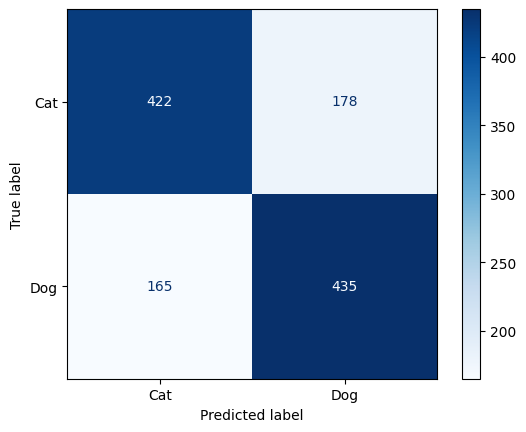

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
